# 2.3 - Macrobond web API - Screening with a Keyword

*Performing coverage checks based on a keyword*

This notebook aims to provide examples of how to use Macrobond's web API call methods as well as insights on the key attributes used to display the output in an understandable format.

We will focus here on using the Search method based on a **keyword** filter. This helps you build a list of time series potentially relating to a common theme.

*Full error handling is omitted for brevity*

***

## Importing packages

In [39]:
import pandas
from matplotlib import pyplot

from macrobond_financial.web import WebClient

***

## Get the data - Keyword: Government Securities Auctions

Note that we are using here the Search endpoint with filters on keyword `text=Government Securities Auctions` and `Frequency=daily` time series in this example.

Feel free to refer to https://api.macrobondfinancial.com/swagger/index.html to get the comprehensive list of web API endpoints and parameters used.

***

## Visualising the data
Let's evaluate Macrobond's coverage for daily time series related to government securities auctions.

In [40]:
with WebClient() as api:
    data_frame = api.entity_search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).to_pd_data_frame()[[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
    ]]
data_frame.head(10)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType
0,esgpfi0232,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
1,phrate0011,"Philippines, Government Securities Auctions, T...",Treasury Bill Rate,[ph],rate,daily,src_phbsp,step,[intrate]
2,esgpfi0217,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
3,esgpfi0237,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
4,esgpfi0222,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
5,esgpfi0345,"Spain, Government Securities Auctions, Inflati...","Inflation Linked Bonds, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
6,phrate0057,"Philippines, Government Securities Auctions, T...",Treasury Bonds,[ph],rate,daily,src_phbsp,stock,[coupon]
7,esgpfi0255,"Spain, Government Securities Auctions, Treasur...","Treasury Bonds, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield]
8,serate0947,"Sweden, Government Securities Auctions, Certif...",NaN,[se],rate,daily,src_swrb,stock,[rate]
9,caboc_totamo_nom,"Canada, Government Securities Auctions, Nomina...",Total,[ca],rate,daily,src_caboc,flow,[amofer]


### Let's make sense of the attribute PriceType

We will use here the metadata endpoint from the web API as detailed in the notebook **1.1 - Macrobond web API - Metadata Navigation**

In [41]:
with WebClient() as api:
    data_frame = api.metadata_get_attribute_information("PriceType")[0].to_pd_data_frame()
data_frame

,name,description,comment,value_type,uses_value_list,can_list_values,can_have_multiple_values,is_database_entity
0,PriceType,Price type,Provides additional information for price rela...,8,True,True,True,False


As the PriceType uses values from list and is not a free text attribute, let's have a look at its values to be used later as a group.

In [42]:
with WebClient() as api:
    df3 = api.metadata_list_values("PriceType").to_pd_data_frame()[
        ["value", "description", "comment"]
    ]
df3

,value,description,comment
0,nav,Net Asset Value,None
1,usplit,Unsplit,Values that are not split adjusted
2,cd,Cash Dividend,None
3,ns,Shares Outstanding,None
4,mcap,Market Cap,None
...,...,...,...
660,injeb,Injectability,None
661,delivcap,Deliverability,None
662,inflow,Inflow,None
663,outflow,Outflow,None


Now that we get a sense of potential groupings we can achieve thanks to the metadata, let's manipulate the ones that will be used.

In [43]:
with WebClient() as api:
    data_frame = api.entity_search(
        text="Government Securities Auctions",
        entity_types="TimeSeries",
        must_have_values={"Frequency": "daily"},
        include_discontinued=False,
    ).to_pd_data_frame()[[
            "Name",
            "FullDescription",
            "Description",
            "Region",
            "Category",
            "Frequency",
            "Source",
            "Class",
            "PriceType",
    ]]

data_frame["RegionString"] = data_frame["Region"].apply(
    lambda x: "" if pandas.isna(x) else ", ".join(map(str, x))
)

# Need to account for NaN values before converting to a string
data_frame["PriceTypeS"] = data_frame["PriceType"].fillna("")
data_frame["PriceTypeString"] = data_frame["PriceTypeS"].apply(
    lambda x: ", ".join(map(str, x))
)

# Mapping the PriceType to its descriptions
mapping = dict(df3[["value", "description"]].values)
data_frame["PriceTypeD"] = data_frame.PriceTypeString.map(mapping)
data_frame.head(1)

,Name,FullDescription,Description,Region,Category,Frequency,Source,Class,PriceType,RegionString,PriceTypeS,PriceTypeString,PriceTypeD
0,esgpfi0232,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],gpfi,daily,src_estesoro,stock,[yield],es,[yield],yield,Yield


### Displaying the new DataFrame
Let's see how our transformations have been applied by isolating on a few columns: `df.iloc[rows,[columns]]`.

In [44]:
df_final = data_frame.iloc[0:12000, [0, 1, 2, 3, 9, 4, 6, 12]]
df_final.head(10)

,Name,FullDescription,Description,Region,RegionString,Category,Source,PriceTypeD
0,esgpfi0232,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
1,phrate0011,"Philippines, Government Securities Auctions, T...",Treasury Bill Rate,[ph],ph,rate,src_phbsp,Average Interest Rate
2,esgpfi0217,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
3,esgpfi0237,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
4,esgpfi0222,"Spain, Government Securities Auctions, Treasur...","Treasury Bills, Average Rate",[es],es,gpfi,src_estesoro,Yield
5,esgpfi0345,"Spain, Government Securities Auctions, Inflati...","Inflation Linked Bonds, Average Rate",[es],es,gpfi,src_estesoro,Yield
6,phrate0057,"Philippines, Government Securities Auctions, T...",Treasury Bonds,[ph],ph,rate,src_phbsp,Coupon
7,esgpfi0255,"Spain, Government Securities Auctions, Treasur...","Treasury Bonds, Average Rate",[es],es,gpfi,src_estesoro,Yield
8,serate0947,"Sweden, Government Securities Auctions, Certif...",NaN,[se],se,rate,src_swrb,Interest Rate
9,caboc_totamo_nom,"Canada, Government Securities Auctions, Nomina...",Total,[ca],ca,rate,src_caboc,Amount Offered


### Group the results by PriceType

In [45]:
df_group1 = df_final.groupby(["PriceTypeD"])["Name"].count().reset_index(name="Count")
df_group1.sort_values(by="Count", ascending=False)

,PriceTypeD,Count
28,Offered,837
36,Yield,586
11,Average Price,437
12,Average Yield,432
29,Price,396
32,Sales,311
18,Demand,306
27,Number of Bids,276
33,Tendered,265
9,Amount of Bids,175


Let's isolate the top 10 results of our dataframe to keep the top price types.

In [46]:
df_group1_top = df_group1.nlargest(10, "Count")

### Group the results by Region

In [47]:
with WebClient() as api:
    df4 = api.metadata_list_values("Region").to_pd_data_frame()[[
        "value", "description"
    ]]

    # Mapping the Region value to its description
    mapping = dict(df4[["value", "description"]].values)
    df_final["RegionD"] = data_frame.RegionString.map(mapping)

    # Applying the grouping
    df_group2 = df_final.groupby(["RegionD"])["Name"].count().reset_index(name="Count")
    df_group2.sort_values(by="Count", ascending=False)
df_group2

,RegionD,Count
0,Canada,269
1,Egypt,4
2,France,516
3,Germany,117
4,Indonesia,1
5,Italy,917
6,Japan,98
7,Kenya,12
8,Philippines,7
9,Poland,1902


In [48]:
df_group2 = (
    df_final.groupby(["RegionD", "PriceTypeD"])["Name"]
    .count()
    .reset_index(name="Count")
)
# df_group2.sort_values(['RegionD','Count'], ascending=False)
heatmap = df_group2.loc[
    (df_group2["RegionD"] == "Poland")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "United States")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
    | (df_group2["RegionD"] == "Sweden")
    & (
        (df_group2["PriceTypeD"] == "Yield")
        | (df_group2["PriceTypeD"] == "Offered")
        | (df_group2["PriceTypeD"] == "Price")
        | (df_group2["PriceTypeD"] == "Sales")
    )
]
heatmap

,RegionD,PriceTypeD,Count
45,Poland,Offered,309
46,Poland,Price,360
47,Poland,Sales,311
48,Poland,Yield,289
60,Sweden,Offered,135
63,Sweden,Yield,184
73,United States,Price,23
74,United States,Yield,20


### Plot the Government Securities Auctions Top by type and region

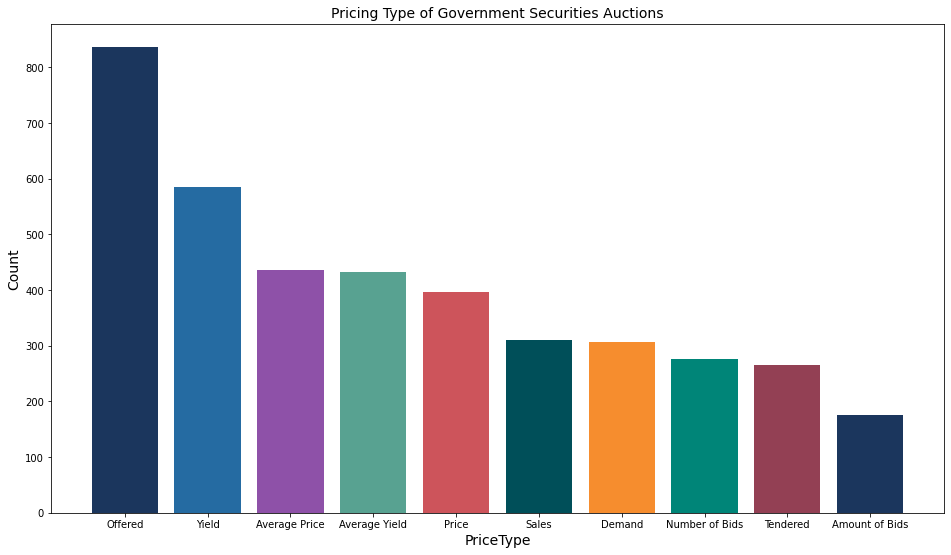

In [49]:
pyplot.rcParams["figure.figsize"] = [16, 9]

colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
]
pyplot.bar(df_group1_top["PriceTypeD"], df_group1_top["Count"], color=colours)
pyplot.title("Pricing Type of Government Securities Auctions", fontsize=14)
pyplot.xlabel("PriceType", fontsize=14)
pyplot.ylabel("Count", fontsize=14)
pyplot.grid(False)
pyplot.autoscale()
pyplot.show()

Let's visualise the Price Type for Poland and Sweden only.

In [50]:
df_final_filtered = df_final.loc[
    (df_final["RegionD"] == "Poland") | (df_final["RegionD"] == "Sweden")
]

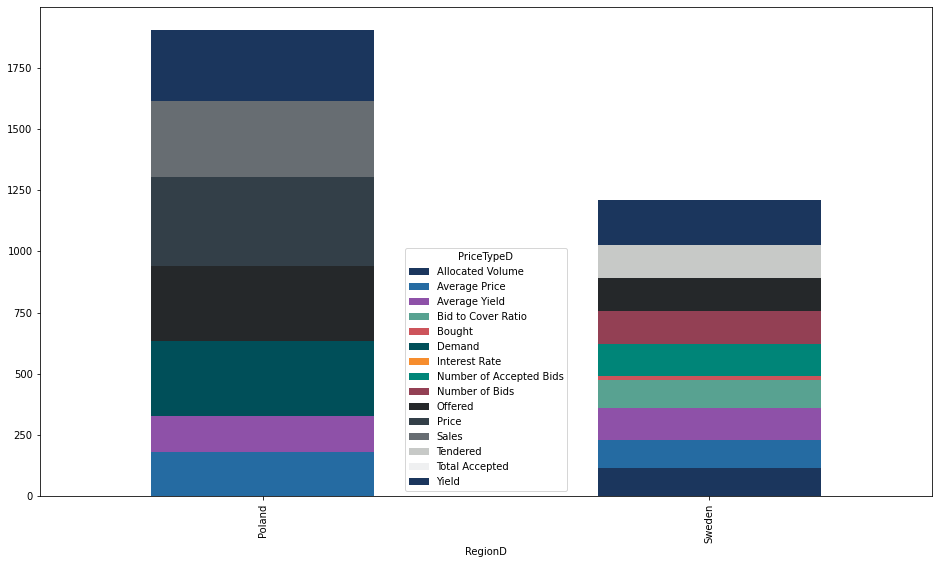

In [51]:
colours = [
    (27 / 255, 54 / 255, 93 / 255),
    (37 / 255, 107 / 255, 162 / 255),
    (142 / 255, 81 / 255, 168 / 255),
    (88 / 255, 162 / 255, 145 / 255),
    (205 / 255, 84 / 255, 91 / 255),
    (0 / 255, 79 / 255, 89 / 255),
    (246 / 255, 141 / 255, 46 / 255),
    (0 / 255, 133 / 255, 120 / 255),
    (147 / 255, 64 / 255, 84 / 255),
    (37 / 255, 40 / 255, 42 / 255),
    (51 / 255, 63 / 255, 72 / 255),
    (103 / 255, 109 / 255, 114 / 255),
    (199 / 255, 201 / 255, 199 / 255),
    (239 / 255, 240 / 255, 241 / 255),
]
df_final_filtered.groupby(["RegionD", "PriceTypeD"]).size().unstack().plot(
    kind="bar", stacked=True, color=colours
)
pyplot.show()